# Hotel Recommendation System using Keras

In [2]:
!pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
import seaborn as sns
import math
import sys
from math import sqrt

from tensorflow.keras.layers import *
from keras import backend as K
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_squared_error, r2_score

from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.utils import add_func
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
hotel_train_data = pd.read_csv("/Users/lufthikautsar/Downloads/Hotel_Recomendation_Model_Traveloka/Eksplorasi Data/goiboi+datafiniti_merge_content-based.csv", sep=',')

In [3]:
hotel_train_data.head(2)

,property_id,count_reviews,sum_reviews,average_reviews,property_name,hotel_description,address,point_of_interest,city,state,...,Two Line Telephone,Utensils (on request),Video/ DVD/ CD Player Available,Voicemail.1,Wardrobe,Washing machine,Western Toilet Seat,Window Opens,Work Station,Working Desk Phone
0,H000001,4,14,3.500000,Baragarh Regency,The standard check-in time is 12:00 PM and the...,"15th Mile, N.H.21,Manali, District Kullu,Himac...","['Hadimba Temple', 'Naggar Village', 'Himalaya...",Manali,Himachal Pradesh,...,0,0,0,0,0,0,1,1,0,0
1,H000002,111,460,4.144144,Asian Suites A- 585,The standard check-in time is 12:00 PM and the...,"A-585, Sushant Lok-1 ,Near Iffco Chowk Metro S...","['Sushant Lok', 'Sahara Mall', 'Amity Internat...",Gurgaon,Haryana,...,0,1,0,0,0,0,0,0,0,0


# Data Pre-processing

In [4]:
hotel_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Columns: 385 entries, property_id to Working Desk Phone
dtypes: float64(3), int64(371), object(11)
memory usage: 4.2+ MB


In [5]:
df = hotel_train_data
df = df.rename(columns={'property_id': 'item_id'})
df.columns = df.columns.str.replace(' ', '_')

In [6]:
df.columns = df.columns.str.replace('/', '')

In [7]:
df.columns = df.columns.str.replace('(', '')

In [8]:
df.columns = df.columns.str.replace(')', '')

In [9]:
df.columns = df.columns.str.replace("'", "_")

In [10]:
df.columns = df.columns.str.replace(",", "_")

In [11]:
df.columns = df.columns.str.replace("&", "-")

In [12]:
df.columns = df.columns.str.replace("-amp;", "-")

In [13]:
df.head(3)

,item_id,count_reviews,sum_reviews,average_reviews,property_name,hotel_description,address,point_of_interest,city,state,...,Two_Line_Telephone,Utensils_on_request,Video_DVD_CD_Player_Available,Voicemail.1,Wardrobe,Washing_machine,Western_Toilet_Seat,Window_Opens,Work_Station,Working_Desk_Phone
0,H000001,4,14,3.500000,Baragarh Regency,The standard check-in time is 12:00 PM and the...,"15th Mile, N.H.21,Manali, District Kullu,Himac...","['Hadimba Temple', 'Naggar Village', 'Himalaya...",Manali,Himachal Pradesh,...,0,0,0,0,0,0,1,1,0,0
1,H000002,111,460,4.144144,Asian Suites A- 585,The standard check-in time is 12:00 PM and the...,"A-585, Sushant Lok-1 ,Near Iffco Chowk Metro S...","['Sushant Lok', 'Sahara Mall', 'Amity Internat...",Gurgaon,Haryana,...,0,1,0,0,0,0,0,0,0,0
2,H000003,4,16,4.000000,Bevvan Resort,The standard check-in time is 12:00 PM and the...,"Cobra Vaddo,Calungate Baga Road, Bardez, Calan...","['Anjuna Beach', 'Calangute Beach', 'Titos lan...",Goa,Goa,...,0,0,0,0,0,0,0,1,0,0


In [14]:
print(df.columns.tolist())

['item_id', 'count_reviews', 'sum_reviews', 'average_reviews', 'property_name', 'hotel_description', 'address', 'point_of_interest', 'city', 'state', 'country', 'latitude', 'longitude', 'property_type', 'hotel_star_rating', 'hotel_facilities', 'room_facilities', '_Bike_on_Rent', '_Cook_Services', '_Drivers_Rest_Room', '24_Hour_Front_Desk', 'ATM__Banking', 'Access_Via_Exterior_Corridors', 'Adjoining_Rooms', 'Air__Rail_Booking', 'Air-Conditioning_-_Central', 'Airport_Transfer_Available__Surcharge', 'Airport_Transfer_Free', 'Amphitheatre', 'Anti-Slip_Ramps', 'Audio_-_Visual_Equipment', 'Ayurvedic_Facilities', 'Ayurvedic_Facilities_', 'Babysitting_Child_Care_surcharge', 'Badminttion_Court', 'Baggage_Room', 'Ballroom', 'Banquet_Facilities', 'Bar__Lounge_', 'Barbecue_Area', 'Basketball_Court_', 'Beauty_Salon_-_on_charge', 'Billiards', 'Board_Room', 'Boating', 'Bowling', 'Business_Center', 'Business_Center_', 'CCTV', 'Camel_Ride', 'Campfire__Bon_Fire', 'Car_Rental', 'Casino', 'Catering', 'Cel

We categorize the features and isolate 'em

In [15]:
sparse_features = ['_Bike_on_Rent', '_Cook_Services', '_Drivers_Rest_Room', '24_Hour_Front_Desk', 'ATM__Banking', 'Access_Via_Exterior_Corridors', 'Adjoining_Rooms', 'Air__Rail_Booking', 'Air-Conditioning_-_Central', 'Airport_Transfer_Available__Surcharge', 'Airport_Transfer_Free', 'Amphitheatre', 'Anti-Slip_Ramps', 'Audio_-_Visual_Equipment', 'Ayurvedic_Facilities', 'Ayurvedic_Facilities_', 'Babysitting_Child_Care_surcharge', 'Badminttion_Court', 'Baggage_Room', 'Ballroom', 'Banquet_Facilities', 'Bar__Lounge_', 'Barbecue_Area', 'Basketball_Court_', 'Beauty_Salon_-_on_charge', 'Billiards', 'Board_Room', 'Boating', 'Bowling', 'Business_Center', 'Business_Center_', 'CCTV', 'Camel_Ride', 'Campfire__Bon_Fire', 'Car_Rental', 'Casino', 'Catering', 'Cell_Phone_Rental', 'Children_s_Park', 'City_Shuttle_Service', 'Clubhouse', 'Coffee_Shop__Cafe', 'Computer_Rental', 'Concierge', 'Conference_Facility', 'Conference_Facility_', 'Courier_Service', 'Courtesy_Coach', 'Currency_Exchange', 'Dance_Performances_on_demand', 'Disabled_Friendly_Facilities_', 'Disabled_Friendly_Rooms', 'Discotheque_', 'Doctor_on_Call', 'Doorman', 'Dry_Cleaning', 'Electronic__Magnetic_Keys', 'Electronic_Check-Out', 'Exhibit_Space', 'Express_Check-In__Check-Out', 'Express_Laundry', 'Extra_Person__Child_-_Share_the_same_room', 'Family_Room', 'Fax_Machine', 'Fire_Exit_Signs', 'Fire_Place_Available_', 'Fire_Safety', 'First-Aid_Kit_at_Front_Desk', 'Fishing', 'Fitness_Equipment', 'Floor_Butler', 'Flower_Shop', 'Food_Facility', 'Free_Internet_Access', 'Free_Local_Calls', 'Front_Desk', 'Full_Time_Operation_for_All_7_Days', 'Fun_Floats', 'Games_Zone', 'Gardens', 'Gift_Shop_', 'Golf_Course', 'Grocery', 'Guide__Sightseeing_Service', 'Health_Club__Gym_Facility_Available', 'Hookah_Lounge', 'Horse_Ride__Chargeable__', 'Hotel_Trading_License', 'In_House_Events_', 'Internet__Fax_Reception_area_only', 'Internet_Access', 'Internet_Access_', 'Internet_Access_-_Surcharge', 'Internet_Access_Free', 'Jacuzzi', 'Karaoke', 'Karaoke_', 'Kids_Play_Zone', 'Kitchen_available_home_cook_food_on_request', 'Laptop_Available_on_Hire', 'Laundry_Service_Available', 'Library', 'Lift__Elevator', 'Limousine_Service_Available', 'Lobby', 'Local_Tour__Travel_Desk', 'Locker_Facility', 'Luggage_Storage', 'Major_Credit_Cards_Accepted', 'Marina_On_Site', 'Massage_Services', 'Massage_Services_', 'Medical_Assistance_Available', 'Meditation_Room', 'Metal_Detectors', 'Mini_Theatre', 'Multi_-_Line_Phone', 'Multi_Cuisine_Restaurant', 'Multi_Cuisine_Restaurant_', 'Multi_Lingual_Staff', 'Nature_Walk', 'Newspapers_In_Lobby', 'Night_Club', 'Non_Smoking_Hotel', 'Non_Smoking_Rooms', 'Open_Air_Restaurant__Dining', 'Open_Air_Restaurant__Dining_', 'Outdoor_Parking_-_Non_Secured', 'Outdoor_Parking_-_Secured', 'Oxygen_Cylinder_on_request', 'Paid_Transfers', 'Parking_Surcharge', 'Parking_Facilities_Available', 'Parking_Facility', 'Party_hall', 'Pest_Control_Facility', 'Pets_Allowed', 'Pick_Up_and_Drop_Rly_Station__Bus_Stand__Temple', 'Picnic_Area', 'Pool_Cafe', 'Pool_Table', 'Poolside_Bar', 'Porter__Bellhop', 'Porter_Services_Available', 'Postal__Parcel_Services', 'Power_Backup', 'Private__Plunge_Pool', 'Private_Beach', 'Public_Restrooms', 'RO_Water_Purification_System', 'Recreation_Zone', 'Restaurant', 'Rooftop_Garden', 'Room_Service', 'Room_Service_', 'Room_Service_24_Hours', 'STD__ISD', 'Safari', 'Sauna', 'Secretarial_Services', 'Security_at_All_Hotel_Entrances', 'Self_Check_-_In', 'Separate_Sitting_Area', 'Shopping_Drop_Facility_on_fixed_timings', 'Ski_Storage', 'Skiing_Facility_Available', 'Smoke_Detector', 'Smoking_Area', 'Smoking_Area_', 'Smoking_Rooms', 'Solarium', 'Spa_On_Site_-_Chargeable', 'Spa_Services_Nearby', 'Spa_Services_Onsite_-_Free', 'Speciality_Restaurant', 'Speciality_Restaurant_', 'Squash_court', 'Stamps_and_Mailing_Facility', 'Suitable_For_Children', 'Suites', 'Swimming_Pool', 'Table_Tennis', 'Taxi_Services', 'Tennis_Court', 'Transfers_Available', 'Translation_Services', 'Trekking', 'Valet_service', 'Veg__Non_Veg_Kitchens_Separate_', 'Vegetarian_Food__Jain_Food_Available', 'Veranda', 'Village_Visit__Chargeable_', 'Virtual_Golf', 'Voicemail', 'Wake-up_Call__Service', 'Water_Dispenser_Available', 'Wedding_Services_Facility', 'Welcome_Drinks', 'Wheelchair_Accessibility_-_Room', 'Whirlpool_Bath__Shower_Cubicle', 'X-Ray_Machine_at_Entrance', 'Yoga_Hall__Classes', '_Hot__Cold_Running_Water', '120_AC', '220_AC', 'Air_Conditioning', 'Air_Conditioning_', 'Air_Cooler', 'Alarm_Clock', 'Attached_Bathroom', 'Balcony', 'Balcony__Terrace', 'Basic_Bathroom_Amenities', 'Bath_Tub', 'Bathrobe', 'Bathrobe_on_request_', 'Bathrobes', 'Bathroom_Amenities', 'Bathtub', 'Bathtub_Only', 'Bedside_Table', 'Bidet', 'Blackout_Drapes', 'Breakfast_Available', 'Breakfast_Available_surcharge', 'Breakfast_chargeable', 'Cable__Satellite__Pay_TV_available', 'CableSatellite_TV', 'Ceiling_Fan', 'Centrally_Heated', 'Channel_Music', 'Citrus_Juicer', 'Climate_Control', 'Clock_Radio', 'Closet', 'Clothes_Dryer', 'Clothes_Hook_in_Bathroom', 'Clothes_Press', 'Coffee_Table', 'Color_TV', 'Complete_Bedding', 'Complimentary_Use_of_Bicycle', 'Computer', 'Cribs_Available', 'Crockery__Cutlery', 'CurtainsShades', 'Custom_Duvets__Linen', 'Daily_Room_Cleaning', 'Desk', 'Desk_in_Room', 'Direct_Dial_Phone', 'Disabled_Friendly_Bathrooms', 'Do-Not-Disturb_Notice', 'Dressing_Area', 'Dry_Cleaning.1', 'Dustbins', 'Electronic_Weighing_Machine', 'Ensuite__Private_Bathroom', 'Extra_Bed__Towels__Linens__Bedding_on_request', 'Extra_Toilteries_on_Demand', 'Free_Newspaper', 'Fruit_Basket', 'Full_Kitchen', 'Gas_Cylinder_-_Chargeable', 'HD__LCD_Satellite_TV', 'HD__LCD_Satellite_TV_', 'Hairdryer', 'Hairdryer_on_request', 'Handheld_Showers', 'Handicapped_Facilities', 'Heating_Facility_on_request', 'Heating_Facility_on_request_', 'Hill_View_from_all_Rooms', 'Hot__Cold_Running_Water', 'Housekeeping', 'Ice_Bucket_on_Demand', 'In-Room_Safe', 'In-room_Storage_Space', 'Induction_Plate', 'International_Switch_Plugs_on_request', 'Internet_Access.1', 'Internet_Connection_In_Room', 'Iron__Ironing_board_available', 'IronIroning_Board', 'Kitchenette', 'Laundry_Service_Available.1', 'Local_Calls_Free', 'Locker_Facility.1', 'Luggage_Rack', 'Luxurious_Feather_Mattresses', 'Makeup__Shaving_Mirror', 'Microwave_Oven_Available_', 'Mineral_Water', 'Mini_Bar', 'Mini_Refrigerator', 'Mini_bar_-_On_Charge_', 'Mirror', 'Modern_Toilet_Facilities', 'Moisturiser', 'Movie_Channels', 'Movies_-_Games_on_demand', 'Newspapers', 'No_Smoking_Room', 'Patio_-_Property', 'Pay_Movies', 'Phone_Messaging_Services', 'Pillow_menu', 'Pinup_Boards', 'Premium_Amenities__Toiletries', 'Premium_Beddings__Hypo-Allergenic_', 'Primium_Bathrooms', 'Private_Garden', 'Radio', 'Reading_Lamps', 'Refrigerator', 'Remote_Control_TV', 'Remote_Controlled_Lights_and_Fan', 'Rollaway_Beds', 'Room_Door_Fitted_with_Lock_and_Key', 'Room_Heater', 'Room_Service.1', 'Room_Service_.1', 'Room_with_WindowVentilation', 'Rooms_with_Attached_Bathrooms', 'Safe_on_request', 'Safe_-_In_-_Room', 'Safe_-_In_-_Room_', 'Sandwich_Maker', 'Sanitary_Bin', 'Second_Bathrooms', 'Separate_Bathtubs_And_Shower', 'Shared_Bathroom', 'Shaving_Kit_Dental_Kit', 'Shoe_Shine', 'Shower', 'Shower_Cap', 'Shower_Caps_Available', 'Shower_Facility_Available', 'Slippers', 'Smoke_Detector.1', 'Snacks__Beverage', 'Sofa_Cum_Bed_Available', 'Sofa_Table__Extra_Seats', 'Sofa_Table__Extra_Seats_', 'Soft_Bar', 'Soundproof_Windows', 'Split_A.C_s', 'Stationery_Kit', 'Stove__Oven', 'Studio_Apartment_-_Large', 'Sufficient_Lighting', 'TV', 'Tea_Coffee_Kettle__Maker', 'Telephone', 'Telephone_in_Toilet', 'Television', 'Toaster', 'Toiletries', 'Two_Line_Telephone', 'Utensils_on_request', 'Video_DVD_CD_Player_Available', 'Voicemail.1', 'Wardrobe', 'Washing_machine', 'Western_Toilet_Seat', 'Window_Opens', 'Work_Station', 'Working_Desk_Phone']

In [16]:
dense_features = ['count_reviews', 'sum_reviews', 'average_reviews']

In [17]:
target = ['hotel_star_rating']

Generate feature columns

In [18]:
def process_dense_feats(df, feats):
    d = df.copy()
    d = d[feats].fillna(0.0)
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    return d

In [19]:
data_dense = process_dense_feats(df, dense_features)

In [20]:
def process_sparse_feats(df, feats):
    d = df.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d

In [21]:
data_sparse = process_sparse_feats(df, sparse_features)

In [22]:
total_data = pd.concat([data_dense, data_sparse], axis=1)

In [23]:
item_enc = LabelEncoder()
df['item'] = item_enc.fit_transform(df['item_id'].values)

In [24]:
total_data['label'] = df['item']

In [63]:
total_data

,count_reviews,sum_reviews,average_reviews,_Bike_on_Rent,_Cook_Services,_Drivers_Rest_Room,24_Hour_Front_Desk,ATM__Banking,Access_Via_Exterior_Corridors,Adjoining_Rooms,...,Utensils_on_request,Video_DVD_CD_Player_Available,Voicemail.1,Wardrobe,Washing_machine,Western_Toilet_Seat,Window_Opens,Work_Station,Working_Desk_Phone,label
0,1.609438,2.708050,1.504077,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,4.718499,6.133398,1.637859,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,1.609438,2.833213,1.609438,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
3,1.945910,3.332205,1.704748,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,5.347108,6.802395,1.667978,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,0.693147,0.693147,0.693147,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1428
1429,0.693147,1.791759,1.791759,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1429
1430,0.693147,1.609438,1.609438,0,0,0,1,0,0,1,...,0,1,1,1,0,0,0,1,0,1430
1431,0.693147,1.791759,1.791759,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1431


In [134]:
# Construct the input of dense features
dense_inputs = []
for f in dense_features:
    _input = Input([1], name=f)
    dense_inputs.append(_input)
# Splicing the inputs together for easy connection to the Dense layer
concat_dense_inputs = Concatenate(axis=1)(dense_inputs)
# Then connect to a fully connected layer whose output is 1 unit, indicating a weighted sum of dense variables
fst_order_dense_layer = Dense(1)(concat_dense_inputs)

In [135]:
# Here the input is constructed separately for each sparse feature,
# The purpose is to facilitate the construction of second-order combined features later
sparse_inputs = []
for f in sparse_features:
    _input = Input([1], name=f)
    sparse_inputs.append(_input)
    
sparse_1d_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_features[i]
    voc_size = total_data[f].nunique()
    # use l2 regularization to prevent overfitting
    reg = tf.keras.regularizers.l2(0.5)
    _embed = Embedding(voc_size, 1, embeddings_regularizer=reg)(_input)
    # Since the result of Embedding is two-dimensional,
    # So if you need to add the Dense layer after Embedding, you need to connect the Flatten layer first
    _embed = Flatten()(_embed)
    sparse_1d_embed.append(_embed)
# Sum the results wi of each embedding lookup
fst_order_sparse_layer = Add()(sparse_1d_embed)

In [136]:
linear_part = Add()([fst_order_dense_layer, fst_order_sparse_layer])

# Split the data into training and test data sets

In [137]:
# embedding size
k = 367

# Only consider second-order intersection of sparse
sparse_kd_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_features[i]
    voc_size = total_data[f].nunique()
    reg = tf.keras.regularizers.l2(0.7)
    _embed = Embedding(voc_size, k, embeddings_regularizer=reg)(_input)
    sparse_kd_embed.append(_embed)

In [138]:
# 1. Splicing together all sparse embeddings to get a matrix of (n, k), where n is the number of features and k is the size of the embedding
concat_sparse_kd_embed = Concatenate(axis=1)(sparse_kd_embed)

In [139]:
# 2. Sum and then square
sum_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(concat_sparse_kd_embed)
square_sum_kd_embed = Multiply()([sum_kd_embed, sum_kd_embed])

In [140]:
# 3. Square first and then sum
square_kd_embed = Multiply()([concat_sparse_kd_embed, concat_sparse_kd_embed])
sum_square_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(square_kd_embed)

In [141]:
# 4. Subtract and divide by 2
sub = Subtract()([square_sum_kd_embed, sum_square_kd_embed])
sub = Lambda(lambda x: x*0.5)(sub)
snd_order_sparse_layer = Lambda(lambda x: K.sum(x, axis=1, keepdims=True))(sub)

# Creating Neural Network

Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

Embeddings are weights that are learned to represent some specific variable like items and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [142]:
flatten_sparse_embed = Flatten()(concat_sparse_kd_embed)

In [143]:
fc_layer = Dropout(0.5)(Dense(512, activation='relu')(flatten_sparse_embed))
fc_layer = Dropout(0.1)(Dense(256, activation='relu')(fc_layer))

In [144]:
fc_layer_output = Dense(1)(fc_layer)

In [145]:
output_layer = Add()([linear_part, snd_order_sparse_layer, fc_layer_output])
output_layer = Activation("sigmoid")(output_layer)

In [146]:
model = Model(dense_inputs+sparse_inputs, output_layer)

In [147]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 _Bike_on_Rent (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 _Cook_Services (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 _Drivers_Rest_Room (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 24_Hour_Front_Desk (InputLayer  [(None, 1)]         0           []                         

In [148]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy"])

## Creating RMSE function for Neural Network

In [149]:
train_data, valid_data = train_test_split(total_data, test_size=0.2, random_state=42)

In [150]:
train_dense_x = [train_data[f].values for f in dense_features]
train_sparse_x = [train_data[f].values for f in sparse_features]

In [151]:
train_label = [train_data['label'].values]

In [152]:
val_dense_x = [valid_data[f].values for f in dense_features]
val_sparse_x = [valid_data[f].values for f in sparse_features]

In [153]:
val_label = [valid_data['label'].values]

In [154]:
history = model.fit(train_dense_x+train_sparse_x, 
          train_label, epochs=15, batch_size=32,
          verbose=1, validation_data=(val_dense_x+val_sparse_x, val_label))

Epoch 1/15
36/36 [==============================] - 453s 4s/step - loss: -12215520.0000 - binary_crossentropy: -12215745.0000 - val_loss: -45256168.0000 - val_binary_crossentropy: -45256192.0000
Epoch 2/15
36/36 [==============================] - 54s 1s/step - loss: -180487648.0000 - binary_crossentropy: -180488464.0000 - val_loss: -469946816.0000 - val_binary_crossentropy: -469946912.0000
Epoch 3/15
36/36 [==============================] - 44s 1s/step - loss: -1310654720.0000 - binary_crossentropy: -1310656768.0000 - val_loss: -2833439488.0000 - val_binary_crossentropy: -2833440000.0000
Epoch 4/15
36/36 [==============================] - 44s 1s/step - loss: -6055604736.0000 - binary_crossentropy: -6055604736.0000 - val_loss: -11274561536.0000 - val_binary_crossentropy: -11274563584.0000
Epoch 5/15
36/36 [==============================] - 45s 1s/step - loss: -19959111680.0000 - binary_crossentropy: -19959111680.0000 - val_loss: -33306697728.0000 - val_binary_crossentropy: -33306697728.

In [155]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_crossentropy', 'val_loss', 'val_binary_crossentropy'])


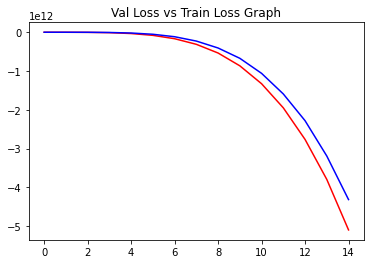

In [156]:
# summarize history for loss
plt.plot(history.history['val_loss'], color='r', label='Val Loss')
plt.plot(history.history['loss'], color='b', label='Train Loss')
plt.title('Val Loss vs Train Loss Graph')
plt.show()

# Making Recommendations

In [74]:
# Creating dataset for making recommendations for the first user
hotel_data = np.array(list(set(df.Item_id)))
hotel_data[:5]

array([0, 1, 2, 3, 4])

In [75]:
user = np.array([1 for i in range(len(hotel_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [76]:
predictions = model.predict([user, hotel_data])

predictions = np.array([a[0] for a in predictions])

recommended_item_ids = (-predictions).argsort()[:5]

recommended_item_ids

array([72, 49, 59, 19, 36], dtype=int64)

In [77]:
# print predicted scores
predictions[recommended_item_ids]

array([0.19043083, 0.18687372, 0.18581037, 0.18546915, 0.18278559],
      dtype=float32)

# Recommend Hotel Cluster for a User

In [99]:
rows = []
hotel = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)
names = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'Item_id' : hotel[i], 'User_id' : 1048}))
test_data = pd.DataFrame(rows)

In [100]:
for idx, (score, name) in enumerate(sorted(zip(recommended_item_ids, names), reverse=True)):
 
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  72.0  for hotel cluster:  1
Score:  59.0  for hotel cluster:  21
Score:  49.0  for hotel cluster:  80
Score:  36.0  for hotel cluster:  41
Score:  19.0  for hotel cluster:  92


In [41]:
hotel_data = np.array(list(set(df['item'])))
hotel_data[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
id_user = 20
user = np.array([id_user for i in range (len(hotel_data))])
user[:10]

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [43]:
predictions = model.predict([user, hotel_data])
predictions = np.array([a[0] for a in predictions])
recommended_hotel_id = (-predictions).argsort()[:10]
recommended_hotel_id

45/45 [==============================] - 0s 5ms/step


array([  6,  83, 138,  21,  84,   4,  62, 115,  77,  34])

In [44]:
predictions[recommended_hotel_id]

array([4.595995 , 4.157644 , 3.9491413, 3.9372382, 3.914852 , 3.8839493,
       3.7683673, 3.7665148, 3.7572596, 3.6514044], dtype=float32)